In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/rz14/Documents/QR_Qishi/QishiQR/')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *

from Utils.lm import gen_strategy, LM_model

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']

model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Build Strategy

In [10]:
ASSET = 'rb'
ASSET_PATH = Path(config['Output path'], ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

commodity = ASSET
exp_list = ['1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1701',
                '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712']



# === Main Routine ===
try:
    strategy = pd.read_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET))
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)
except:
    strategy = gen_strategy(commodity, exp_list, number_of_states, model_order, data_root_dir=DATA_DIR, output=OUTPUT_DIR)
    strategy.to_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET),index=False)
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

# Validate

In [ ]:
import pandas as pd
from Backtesting.Vectorized.lm_validation import LmValidation

lm_validation = LmValidation(slm, symbol='rb*', data_dir=r'../../Output', valid_dir=r'../../Validation', max_order=8)
lm_validation.run()

# Test one contract

In [12]:
from Backtesting.Vectorized.models import OneContractTest
start = '20161101'
end = '20161231'
max_order=7
test1 = OneContractTest(DATA_DIR, OUTPUT_DIR, slm)
test1.build('ag', '1701', max_order, freq, offset, start, end, None)
test1.run()

In [ ]:
test1.plot()
test1.performance

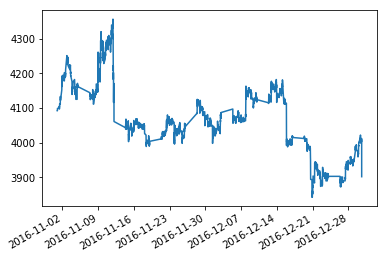

In [14]:
test1.test_data['LastPrice'].plot()

# Compare different contracts

In [29]:
from Backtesting.Vectorized.models import MultiContractTest
start = '20161101'
end = '20161231'
exps=['1701','1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712']

test2 = MultiContractTest(DATA_DIR, OUTPUT_DIR, slm)
test2.build('rb', exps, 4, freq, offset, start, end, 'fixed')
test2.run()

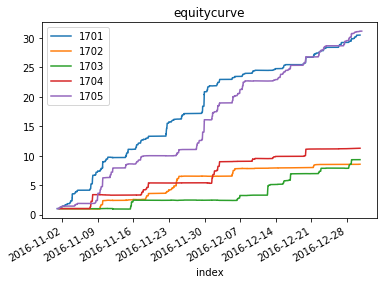

In [30]:
test2.plot()

In [28]:
pd.DataFrame([x.performance for x in test2.ensemble.ensembles])

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,10.988173,0.654539,-0.002913,0.009336,0.007461,-0.041510,0.075297,-0.011666,3.205304,14.891903,3948,30.454264,0.823708
1,5.435388,0.171277,-0.004021,0.007086,0.003541,-0.027489,0.037688,-0.083894,1.762218,7.877866,2128,8.536190,0.590695
2,5.775283,0.188846,-0.005530,0.010380,0.004460,-0.058470,0.043363,-0.115700,1.877075,8.174752,1863,9.309225,0.477724
3,8.313171,0.232920,-0.005015,0.012075,0.005903,-0.035495,0.042529,-0.033603,2.407797,7.004537,1736,11.248465,0.517857
4,11.773592,0.669429,-0.003228,0.010314,0.008122,-0.040607,0.081418,-0.016788,3.195011,14.214621,3709,31.124287,0.813966


In [ ]:
test2.plot()
plt.legend(exps)

In [ ]:
test2.performance.index=exps
test2.performance